### 動画データを読み込んで前処理する

In [1]:
#PATHのリストを取得する
import os

#クラス名を取得する
import collections

#ランダムに振り分ける
import tqdm
import pathlib
import random

#前処理
import tensorflow as tf
import cv2
import numpy as np

#学習
import keras
from keras import layers
import einops

from keras.layers import Layer
from keras.utils import register_keras_serializable
from keras.callbacks import EarlyStopping

#結果の可視化
import matplotlib.pyplot as plt
import seaborn as sns

2024-07-05 12:21:41.899806: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 12:21:42.018204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 12:21:42.018332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 12:21:42.031271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 12:21:42.075593: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from pathlib import Path
import shutil

# 移動元と移動先のディレクトリパスを設定
source_dir = Path('data/subset')
destination_dir = Path('data/cropped_video')

# 移動先のディレクトリが存在しない場合は作成
destination_dir.mkdir(parents=True, exist_ok=True)

# 移動元ディレクトリ下のすべての.mp4ファイルを検索
for mp4_file in source_dir.glob('**/*.mp4'):
    # ファイルを移動先ディレクトリに移動
    shutil.move(str(mp4_file), str(destination_dir / mp4_file.name))

print("ファイルの移動が完了しました。")


ファイルの移動が完了しました。


In [3]:
mov_dir = os.path.join("data", "cropped_video")

PATHのリストを取得する

In [4]:
def list_files_per_class(mov_dir):

  files = []
  for root, dirs, f in os.walk(mov_dir):
      
      for file in f:
          
          if file.endswith(".mp4"):
              
              files.append(os.path.join(root, file))
      
  
  return files

クラス名を取得する

In [5]:
def get_class(fname):

  return fname.split('_')[-2]

def get_files_per_class(files):

  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
    
  return files_for_class

ランダムに振り分け

In [6]:
def organize_files(to_dir, file_names):
    for fn in tqdm.tqdm(file_names):
        class_name = get_class(fn)
        class_dir = to_dir /class_name
        
        if not class_dir.exists():
            class_dir.mkdir(parents=True, exist_ok=True)
        
        original_file = pathlib.Path(fn)
        
        output_file = class_dir / original_file.name
        
        original_file.rename(output_file)
        
        
def split_class_lists(files_for_class, count):

  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder             
            
        
def organize_subset(mov_dir, num_classes, splits, download_dir):

  files = list_files_per_class(mov_dir)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    organize_files(split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs        

前処理

In [7]:
def format_frames(frame, output_size):
  
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 2):

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  
  def __init__(self, path, n_frames, training = False):
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [8]:
download_dir = pathlib.Path('./data/subset/')
subset_paths = organize_subset(mov_dir, 
                        num_classes = 6, 
                        splits = {"train": 500, "val": 100, "test": 0},
                        download_dir = download_dir)

train :


100%|██████████| 3000/3000 [00:00<00:00, 37913.93it/s]


val :


100%|██████████| 600/600 [00:00<00:00, 43995.43it/s]


test :


0it [00:00, ?it/s]


トレーニング、検証、およびテストのセット（`train_ds`、`val_ds`、`test_ds`）の作成

In [9]:
n_frames = 24
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

2024-07-05 12:22:36.831249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 12:22:36.944527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 12:22:36.944569: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 12:22:36.948133: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-05 12:22:36.948178: I external/local_xla/xla/stream_executor

### モデルの構築

In [10]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

# Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()


@keras.saving.register_keras_serializable(package="MyCustomLayers")
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding, **kwargs):
        super().__init__(**kwargs)  # 親クラスのコンストラクタを呼び出す
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.seq = keras.Sequential([
            # 2次元平面に対する畳み込み カーネルサイズ(1,7,7)
            keras.layers.Conv3D(filters=self.filters,
                                kernel_size=(1, self.kernel_size[1], self.kernel_size[2]),
                                padding=self.padding),
            # 時間方向に対する畳み込み　カーネルサイズ(3,1,1)
            keras.layers.Conv3D(filters=self.filters,
                                kernel_size=(self.kernel_size[0], 1, 1),
                                padding=self.padding)
        ])
  
    def call(self, x):
        return self.seq(x)
    
    def get_config(self):
        config = super().get_config()  # 親クラスの設定を取得
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding
        })
        return config

@keras.saving.register_keras_serializable(package="CustomLayers")
class ResidualMain(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ResidualMain, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=self.filters,
                        kernel_size=self.kernel_size,
                        padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=self.filters,
                        kernel_size=self.kernel_size,
                        padding='same'),
            layers.LayerNormalization()
        ])
  
    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super(ResidualMain, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size
        })
        return config

@keras.saving.register_keras_serializable(package="CustomLayers")
class Project(Layer):
    def __init__(self, units, **kwargs):
        super(Project, self).__init__(**kwargs)
        self.units = units
        self.seq = keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super(Project, self).get_config()
        config.update({'units': self.units})
        return config

@keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def add_residual_block(input, filters, kernel_size):

  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

@keras.saving.register_keras_serializable(package="CustomLayers")
class ResizeVideo(Layer):
    def __init__(self, height, width, **kwargs):
        super(ResizeVideo, self).__init__(**kwargs)
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        # b stands for batch size, t stands for time, h stands for height, 
        # w stands for width, and c stands for the number of channels.
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(
            images, '(b t) h w c -> b t h w c',
            t=old_shape['t'])
        return videos

    def get_config(self):
        config = super(ResizeVideo, self).get_config()
        config.update({
            'height': self.height,
            'width': self.width
        })
        return config
  
input_shape = (None, 48, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(6, activation='softmax')(x)

model = keras.Model(input, x)
   


In [11]:
frames, label = next(iter(train_ds))
model.build(frames)

2024-07-05 12:22:41.010047: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


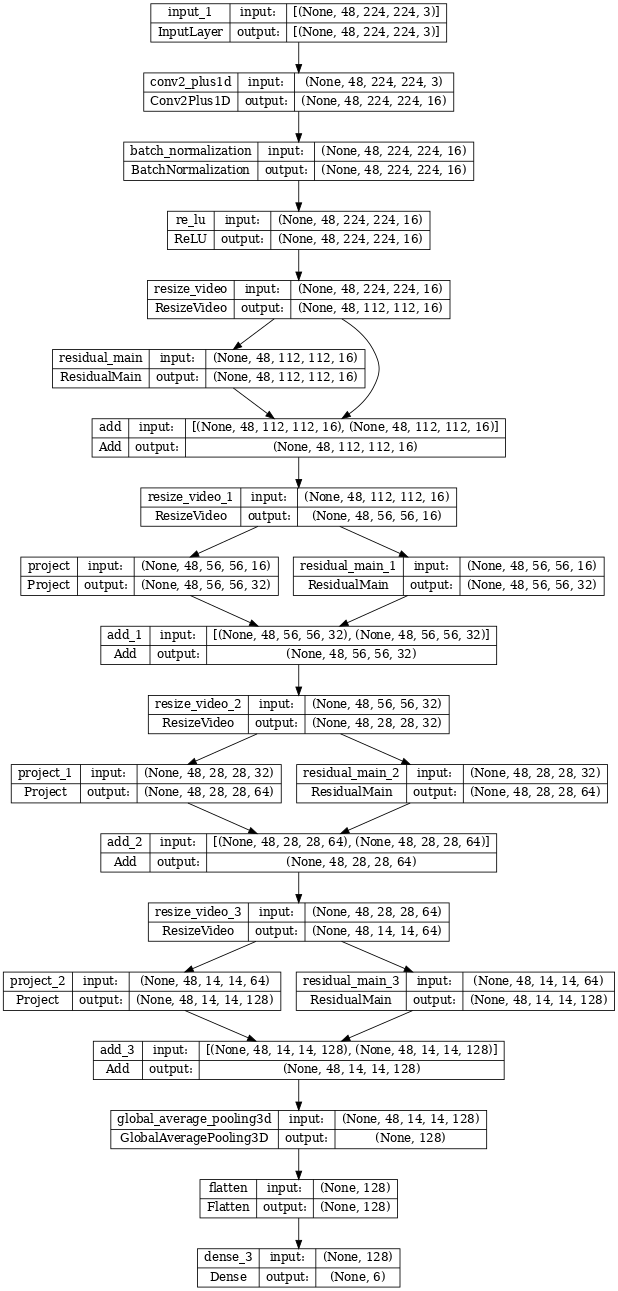

In [12]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

### モデルのトレーニング

In [13]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [14]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

history = model.fit(x = train_ds,
                    epochs = 20, 
                    validation_data = val_ds,
                    callbacks=[early_stopping]
                    )

Epoch 1/20


/home/tensorflow_GPU/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-07-05 12:22:51.734278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-05 12:22:51.912839: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-05 12:23:00.036683: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f70240652f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-05 12:23:00.036717: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-05 12:23:00.053670: I tensorflow/compiler/mlir/tensorflow/utils/dump_ml

375/375 [==============================] - 1162s 3s/step - loss: 1.7647 - accuracy: 0.2400 - val_loss: 2.2157 - val_accuracy: 0.2033
Epoch 2/20


2024-07-05 12:42:08.480238: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 5609069542561310188
2024-07-05 12:42:08.480317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15228168855778908305
2024-07-05 12:42:08.480332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1266965449465010059


375/375 [==============================] - 1126s 3s/step - loss: 1.4074 - accuracy: 0.3810 - val_loss: 1.3508 - val_accuracy: 0.3783
Epoch 3/20
375/375 [==============================] - 1195s 3s/step - loss: 1.1955 - accuracy: 0.5083 - val_loss: 1.1159 - val_accuracy: 0.5217
Epoch 4/20
375/375 [==============================] - 1150s 3s/step - loss: 1.0561 - accuracy: 0.5697 - val_loss: 0.8881 - val_accuracy: 0.6417
Epoch 5/20
375/375 [==============================] - 887s 2s/step - loss: 0.9217 - accuracy: 0.6433 - val_loss: 0.8832 - val_accuracy: 0.6667
Epoch 6/20
375/375 [==============================] - 915s 2s/step - loss: 0.8279 - accuracy: 0.6833 - val_loss: 1.3325 - val_accuracy: 0.4933
Epoch 7/20
375/375 [==============================] - 914s 2s/step - loss: 0.7845 - accuracy: 0.7030 - val_loss: 0.7186 - val_accuracy: 0.7617
Epoch 8/20
375/375 [==============================] - 915s 2s/step - loss: 0.7085 - accuracy: 0.7427 - val_loss: 0.7002 - val_accuracy: 0.7550
Epoch 9

### 結果の可視化

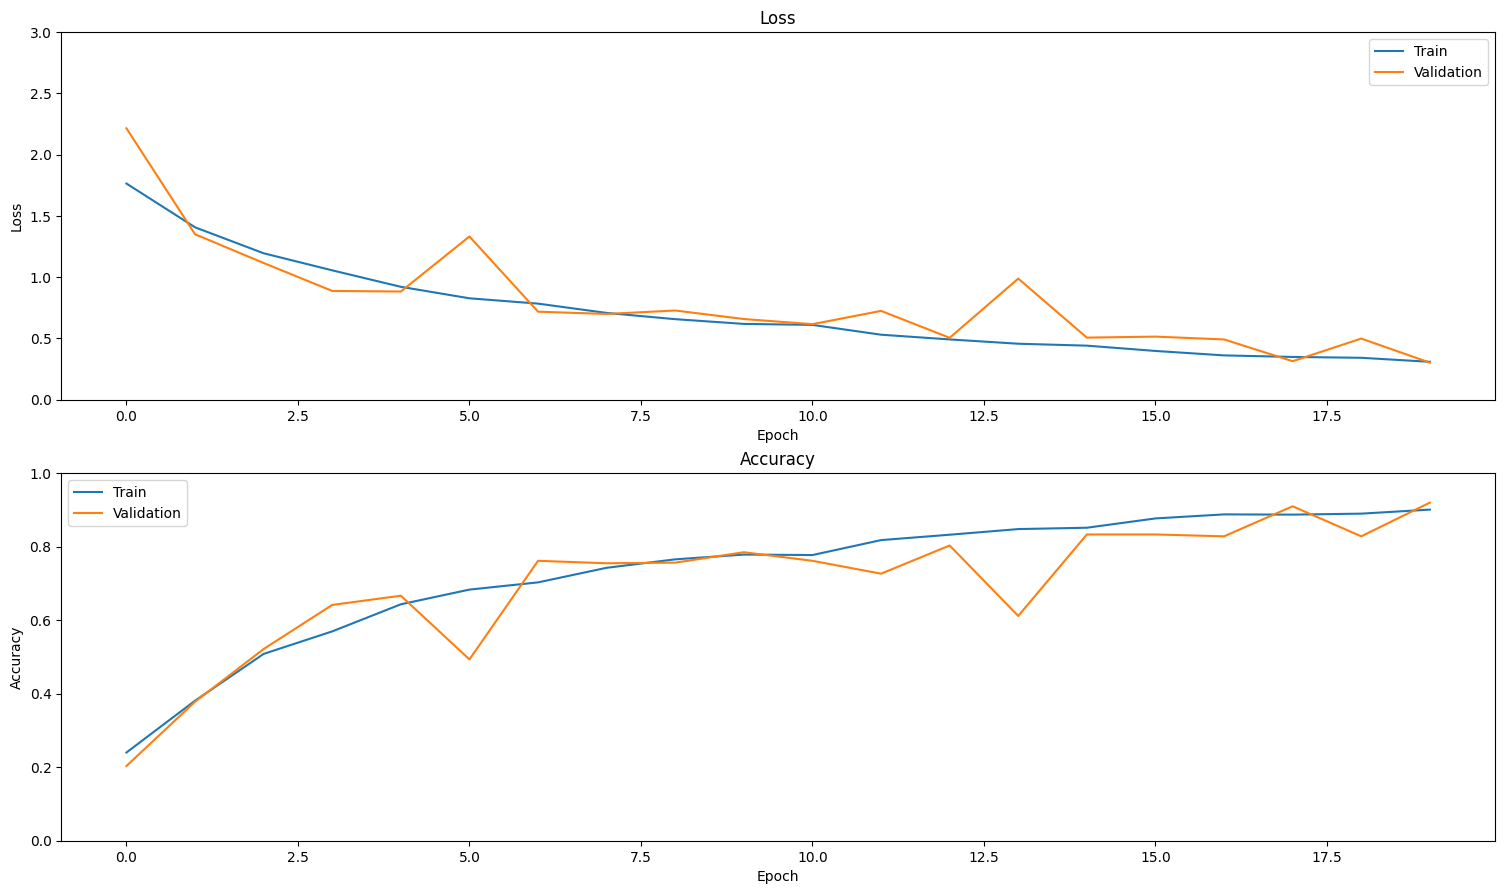

In [15]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [16]:
def get_actual_predicted_labels(dataset): 

  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [17]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Phase')
  ax.set_ylabel('Actual Phase')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [18]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

375/375 [==============================] - 595s 2s/step


2024-07-08 13:02:23.061016: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15228168855778908305


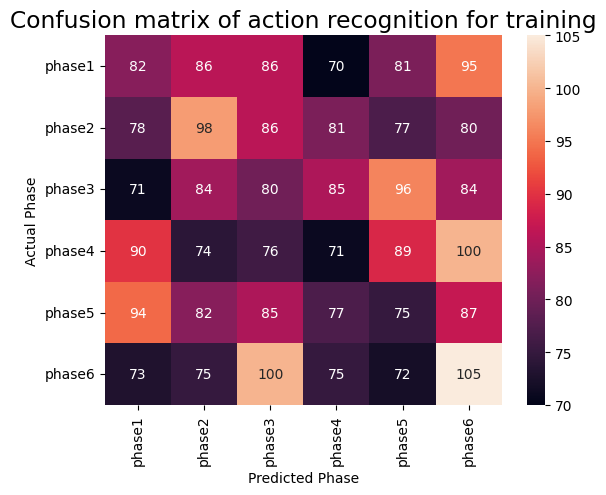

In [19]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [20]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

2024-07-08 13:02:24.901725: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15228168855778908305


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [21]:
def calculate_classification_metrics(y_actual, y_pred, labels):

  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [22]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [23]:
precision

{'phase1': 0.1680327868852459,
 'phase2': 0.1963927855711423,
 'phase3': 0.15594541910331383,
 'phase4': 0.15468409586056645,
 'phase5': 0.15306122448979592,
 'phase6': 0.19056261343012704}

In [24]:
recall

{'phase1': 0.164,
 'phase2': 0.196,
 'phase3': 0.16,
 'phase4': 0.142,
 'phase5': 0.15,
 'phase6': 0.21}

In [25]:
model.save("test_model_9.keras")